# Install Required Dependencies

In [1]:
!pip install vitaldb

In [2]:
import datetime
import os
import random
import time

from timeit import default_timer as timer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import vitaldb

# Set Random Seed for Reproducibility

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
os.environ['PYTHONASHSEED'] = str(seed)

# Set Up Local Data Caches

Since the VitalDB data is static, local copies are stored and reused to avoid expensive downloads and to speed up data processing.

The default directory defined below is already in the project `.gitignore` file. If later modified, it should also be added to the project `.gitignore`.

In [4]:
VITALDB_CACHE = './vitaldb_cache'
VITAL_ALL = 'vital_all'
VITAL_MINI = 'vital_mini'
VITAL_METADATA = 'metadata'

In [5]:
!mkdir -p $VITALDB_CACHE
!mkdir -p $VITALDB_CACHE/$VITAL_ALL
!mkdir -p $VITALDB_CACHE/$VITAL_MINI
!mkdir -p $VITALDB_CACHE/$VITAL_METADATA
!ls -l $VITALDB_CACHE

total 77437752
drwxr-xr-x     4 sphillips  staff          128 Apr  7 23:38 docs
drwxr-xr-x     4 sphillips  staff          128 Apr  7 23:03 metadata
drwxr-xr-x     6 sphillips  staff          192 Apr  7 23:12 osfs
drwx------@ 6390 sphillips  staff       204480 Apr  7 17:38 vital_all
drwxr-xr-x  3299 sphillips  staff       105568 Apr  7 23:15 vital_mini
-rw-r--r--     1 sphillips  staff  39648128512 Apr  7 22:39 vital_mini.tar


# OSFS Bulk Data Download

**This step is not required, but will significantly speed up downstream processing and avoid a high volume of API requests to the VitalDB web site.**

The cache population code checks if OSFS bulk download data of VitalDB vital files is locally available.

- Manually downloaded the OSF Store archives from the following site: https://osf.io/dtc45/
    - `Vital Files 0001-2000`
    - `Vital Files 2001-4000`
    - `Vital Files 4001-6388`
- Once the `OSF Storage (United States)` link is clicked a `Download as zip` link will appear.
- Once downloaded, extract each of the 3 zip archives.
- Move all files from each of the unzip directories into the `${VITALDB_CACHE}/${VITAL_ALL}` directory.

In [6]:
# Returns the Pandas DataFrame for the specified dataset.
#   One of 'cases', 'labs', or 'trks'
# If the file exists locally, create and return the DataFrame.
# Else, download and cache the csv first, then return the DataFrame.
def vitaldb_dataframe_loader(dataset_name):
    if dataset_name not in ['cases', 'labs', 'trks']:
        raise ValueError(f'Invalid dataset name: {dataset_name}')
    file_path = f'{VITALDB_CACHE}/{VITAL_METADATA}/{dataset_name}.csv'
    if os.path.isfile(file_path):
        print(f'{dataset_name}.csv exists locally.')
        df = pd.read_csv(file_path)
        return df
    else:
        print(f'downloading {dataset_name} and storing in the local cache for future reuse.')
        df = pd.read_csv(f'https://api.vitaldb.net/{dataset_name}')
        df.to_csv(file_path, index=False)
        return df

# Cases

In [7]:
cases = vitaldb_dataframe_loader('cases')
cases = cases.set_index('caseid')
cases.shape

cases.csv exists locally.


(6388, 73)

In [8]:
cases.index.nunique()

6388

In [9]:
cases.head()

,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
caseid,,,,,,,,,,,,,,,,,,,,,
1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,0,...,0,120,0.0,100,70,0,10,0,0,0
2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,0,...,0,150,0.0,0,100,0,20,0,0,0
3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,0,...,0,0,0.0,0,50,0,0,0,0,0
4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,1,...,0,80,0.0,100,100,0,50,0,0,0
5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,13,...,0,0,0.0,0,160,0,10,900,0,2100


In [10]:
cases['sex'].value_counts()

sex
M    3243
F    3145
Name: count, dtype: int64

# Tracks

In [11]:
trks = vitaldb_dataframe_loader('trks')
trks = trks.set_index('caseid')
trks.shape

trks.csv exists locally.


(486449, 2)

In [12]:
trks.index.nunique()

6388

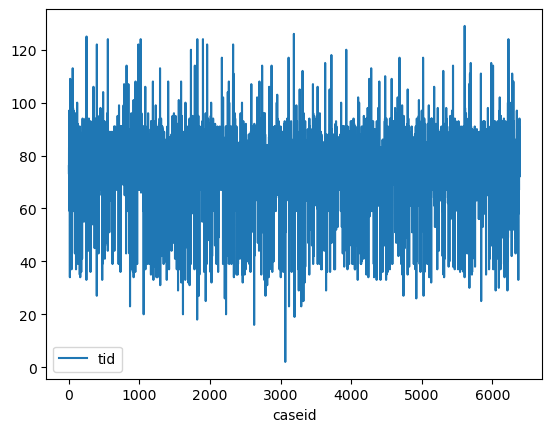

In [13]:
trks.groupby('caseid')[['tid']].count().plot();

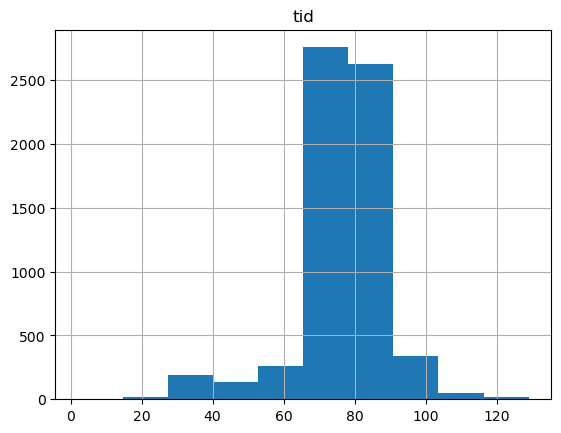

In [14]:
trks.groupby('caseid')[['tid']].count().hist();

In [15]:
trks.groupby('tname').count().sort_values(by='tid', ascending=False)

,tid
tname,
Solar8000/HR,6387
Solar8000/PLETH_SPO2,6386
Solar8000/PLETH_HR,6386
Primus/CO2,6362
Primus/PAMB_MBAR,6361
...,...
Orchestra/AMD_VOL,1
Solar8000/ST_V5,1
Orchestra/NPS_VOL,1


## Parameters of Interest

### Hemodynamic Parameters Reference
https://vitaldb.net/dataset/?query=overview#h.f7d712ycdpk2

**Solar8000/ART_MBP**

mean blood pressure

Parameter, Description, Type/Hz, Unit

Solar8000/ART_MBP, Mean arterial pressure, N, mmHg

In [16]:
trks[trks['tname'].str.contains('Solar8000/ART_MBP')].shape

(3724, 2)

**SNUADC/ART**

arterial blood pressure waveform

Parameter, Description, Type/Hz, Unit

SNUADC/ART, Arterial pressure wave, W/500, mmHg

In [17]:
trks[trks['tname'].str.contains('SNUADC/ART')].shape

(3645, 2)

**SNUADC/ECG_II**

electrocardiogram waveform

Parameter, Description, Type/Hz, Unit

SNUADC/ECG_II, ECG lead II wave, W/500, mV

In [18]:
trks[trks['tname'].str.contains('SNUADC/ECG_II')].shape

(6355, 2)

**BIS/EEG1_WAV**

electroencephalogram waveform

Parameter, Description, Type/Hz, Unit

BIS/EEG1_WAV, EEG wave from channel 1, W/128, uV

In [19]:
trks[trks['tname'].str.contains('BIS/EEG1_WAV')].shape

(5871, 2)

# Cases of Interest

These are the subset of case ids for which modelling and analysis will be performed based upon inclusion criteria and waveform data availability.

In [20]:
TRACK_NAMES = ['SNUADC/ART', 'SNUADC/ECG_II', 'BIS/EEG1_WAV']

In [21]:
# As in the paper, select cases which meet the following criteria:
#
# For patients, the inclusion criteria were as follows:
# (1) adults (age >= 18)
# (2) administered general anaesthesia
# (3) undergone non-cardiac surgery. 
#
# For waveform data, the inclusion criteria were as follows:
# (1) no missing monitoring for ABP, ECG, and EEG waveforms
# (2) no cases containing false events or non-events due to poor signal quality
#     (checked in second stage of data preprocessing)

# adult
inclusion_1 = cases.loc[cases['age'] >= 18].index
print(f'{len(cases)-len(inclusion_1)} cases excluded, {len(inclusion_1)} remaining due to age criteria')

# general anesthesia
inclusion_2 = cases.loc[cases['ane_type'] == 'General'].index
print(f'{len(cases)-len(inclusion_2)} cases excluded, {len(inclusion_2)} remaining due to anesthesia criteria')

# non-cardiac surgery
inclusion_3 = cases.loc[
    ~cases['opname'].str.contains("cardiac", case=False)
    & ~cases['opname'].str.contains("aneurysmal", case=False)
].index
print(f'{len(cases)-len(inclusion_3)} cases excluded, {len(inclusion_3)} remaining due to non-cardiac surgery criteria')

# ABP, ECG, EEG waveforms
TRACK_NAMES = ['SNUADC/ART', 'SNUADC/ECG_II', 'BIS/EEG1_WAV']
inclusion_4 = trks.loc[trks['tname'].isin(TRACK_NAMES)].index.value_counts()
inclusion_4 = inclusion_4[inclusion_4 == len(TRACK_NAMES)].index
print(f'{len(cases)-len(inclusion_4)} cases excluded, {len(inclusion_4)} remaining due to missing waveform data')

cases_of_interest_idx = inclusion_1 \
    .intersection(inclusion_2) \
    .intersection(inclusion_3) \
    .intersection(inclusion_4)

cases_of_interest = cases.loc[cases_of_interest_idx]

print()
print(f'{cases_of_interest_idx.shape[0]} out of {cases.shape[0]} total cases remaining after exclusions applied')

57 cases excluded, 6331 remaining due to age criteria
345 cases excluded, 6043 remaining due to anesthesia criteria
14 cases excluded, 6374 remaining due to non-cardiac surgery criteria
3019 cases excluded, 3369 remaining due to missing waveform data

3296 out of 6388 total cases remaining after exclusions applied


In [22]:
cases_of_interest.head(n=5)

,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
caseid,,,,,,,,,,,,,,,,,,,,,
1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,0,...,0,120,0.0,100,70,0,10,0,0,0
3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,0,...,0,0,0.0,0,50,0,0,0,0,0
4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,1,...,0,80,0.0,100,100,0,50,0,0,0
7,5124,0,15770,477,14817.0,3177,14577,-154320,623280,3,...,0,0,0.0,0,120,0,0,0,0,0
10,2175,0,20992,-1743,21057.0,2457,19857,-220740,3580860,1,...,0,90,0.0,0,110,0,20,500,0,600


# Tracks of Interest

These are the subset of tracks (waveforms) for the cases of interest identified above.

In [23]:
# A single case maps to one or more waveform tracks. Select only the tracks required for analysis.
trks_of_interest = trks.loc[cases_of_interest_idx][trks.loc[cases_of_interest_idx]['tname'].isin(TRACK_NAMES)]
trks_of_interest.shape

(9888, 2)

In [24]:
trks_of_interest.head(n=5)

,tname,tid
caseid,,
1,BIS/EEG1_WAV,0aa685df768489a18a5e9f53af0d83bf60890c73
1,SNUADC/ART,724cdd7184d7886b8f7de091c5b135bd01949959
1,SNUADC/ECG_II,8c9161aaae8cb578e2aa7b60f44234d98d2b3344
3,BIS/EEG1_WAV,3a3fe9248e00cd20c3442960d92405c4bb405a05
3,SNUADC/ART,54be86b8ba1eb9c42a572b5824310eb6c9f19aef


In [25]:
trks_of_interest_idx = trks_of_interest.set_index('tid').index
trks_of_interest_idx.shape

(9888,)

## Build Tracks Cache for Local Processing

Tracks data are large and therefore expensive to download every time used.
By default, the vital file format stores all tracks for each case internally. Since only certain tracks per case are required, each vital file can be further truncated to only store the tracks for needed waveforms.

In [26]:
# Maximum number of cases of interest for which to download data.
# Set to a small value for demo purposes, else set to None to disable and download all.
MAX_CASES = None
#MAX_CASES = 10

In [27]:
# Ensure the full vital file dataset is available for cases of interest.
count_downloaded = 0
count_present = 0

#for i, idx in enumerate(cases.index):
for i, idx in enumerate(cases_of_interest_idx):
    if MAX_CASES and i >= MAX_CASES:
        break

    full_path = f'{VITALDB_CACHE}/{VITAL_ALL}/{idx:04d}.vital'
    if not os.path.isfile(full_path):
        print(f'Missing vital file: {full_path}')
        # Download and save the file.
        vf = vitaldb.VitalFile(idx)
        vf.to_vital(full_path)
        count_downloaded += 1
    else:
        count_present += 1

print()
print(f'Count of cases of interest:           {cases_of_interest_idx.shape[0]}')
print(f'Count of vital files downloaded:      {count_downloaded}')
print(f'Count of vital files already present: {count_present}')


Count of cases of interest:           3296
Count of vital files downloaded:      0
Count of vital files already present: 3296


In [28]:
# Convert vital files to "mini" versions including only the subset of tracks based on TRACK_NAMES defined above.
# Only perform conversion for the cases of interest.
# NOTE: If this cell is interrupted, it can be restarted and will continue where it left off.
count_minified = 0
count_present = 0

for i, idx in enumerate(cases_of_interest_idx):
    if MAX_CASES and i >= MAX_CASES:
        break
    
    full_path = f'{VITALDB_CACHE}/{VITAL_ALL}/{idx:04d}.vital'
    mini_path = f'{VITALDB_CACHE}/{VITAL_MINI}/{idx:04d}_mini.vital'
    if not os.path.isfile(mini_path):
        print(f'Creating mini vital file: {idx}')
        vf = vitaldb.VitalFile(full_path, TRACK_NAMES)
        vf.to_vital(mini_path)
        count_minified += 1
    else:
        count_present += 1

print()
print(f'Count of cases of interest:           {cases_of_interest_idx.shape[0]}')
print(f'Count of vital files minified:        {count_minified}')
print(f'Count of vital files already present: {count_present}')


Count of cases of interest:           3296
Count of vital files minified:        0
Count of vital files already present: 3296


# Track Plotting Examples

These examples show multiple ways of accessing the same track data.

In [29]:
tmp_vf_path = f'{VITALDB_CACHE}/{VITAL_MINI}/0001_mini.vital'

In [30]:
tmp_vf = vitaldb.VitalFile(tmp_vf_path)
tmp_vf.get_track_names()

['SNUADC/ART', 'SNUADC/ECG_II', 'BIS/EEG1_WAV']

**`vitaldb.VitalFile.get_track_samples()`**

In [31]:
tmp_art_00 = tmp_vf.get_track_samples(TRACK_NAMES[0], 1/100)
tmp_art_00.shape

(1154115,)

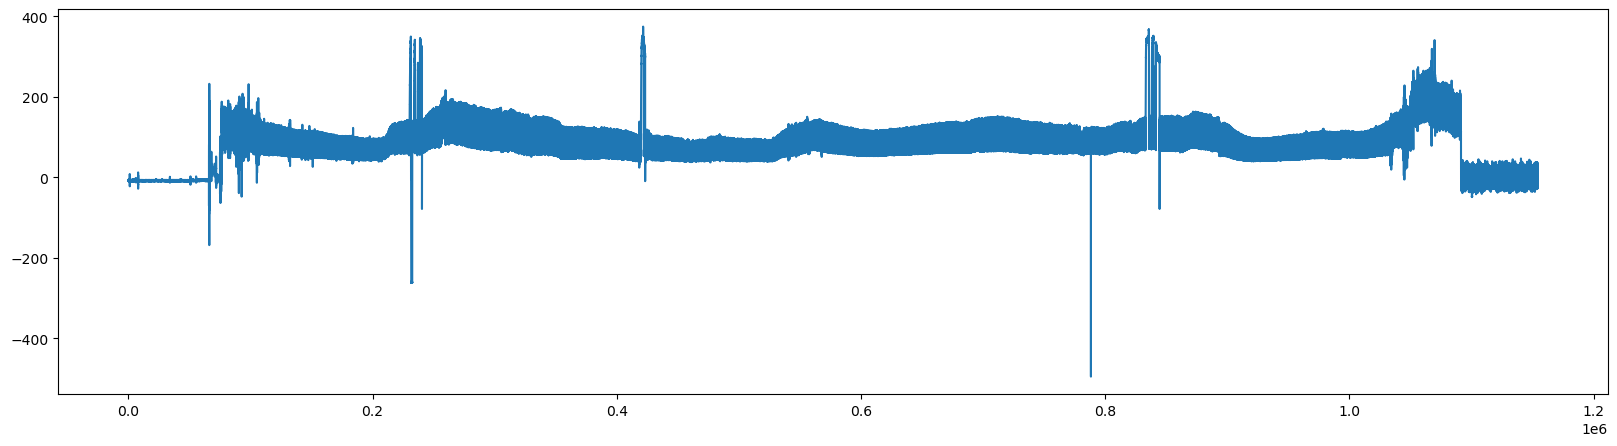

In [32]:
plt.figure(figsize=(20, 5))
plt.plot(tmp_art_00)
plt.show()

**`vitaldb.VitalFile.to_numpy()`**

In [33]:
tmp_art_01 = tmp_vf.to_numpy(TRACK_NAMES[0], 1/100)
tmp_art_01.shape

(1154115, 1)

In [34]:
type(tmp_art_01)

numpy.ndarray

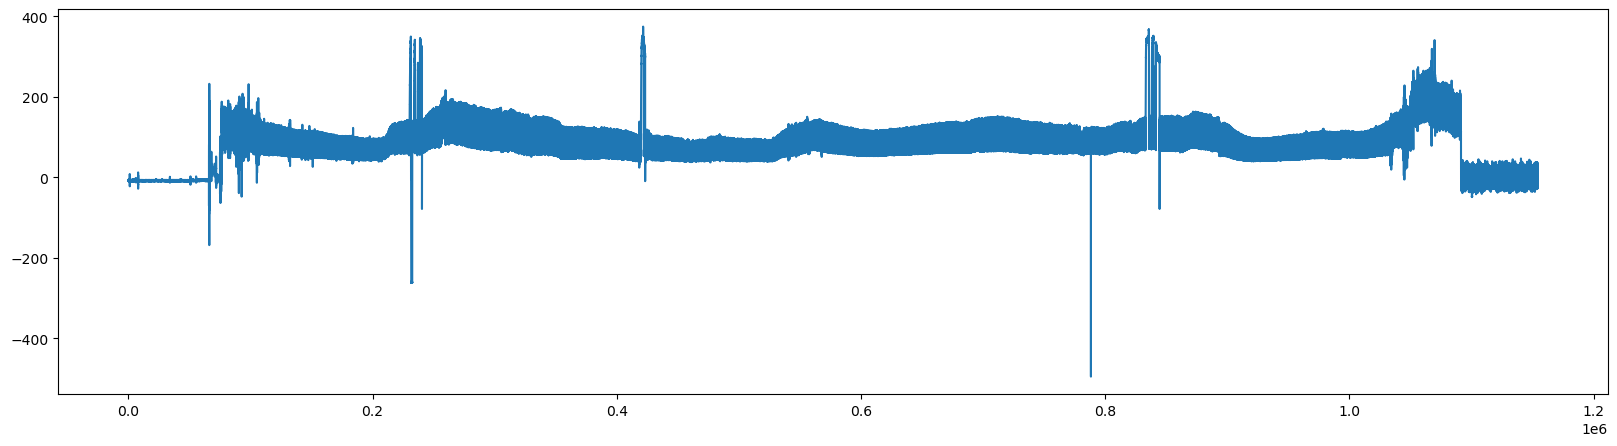

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(tmp_art_01)
plt.show()

**`vitaldb.VitalFile.get_samples()`**

This option allows returning timestamps as well.

In [36]:
tmp_art_02 = tmp_vf.get_samples(TRACK_NAMES[0], 1/100, return_timestamp=True)
tmp_art_02

([array([4.10244480e+09, 4.10244480e+09, 4.10244480e+09, ...,
         4.10245634e+09, 4.10245634e+09, 4.10245634e+09]),
  array([        nan,         nan,         nan, ..., -20.65918  ,
          32.663483 ,  -4.8598633], dtype=float32)],
 ['Time', 'SNUADC/ART'])

In [37]:
tmp_art_02[0][0][-1] - tmp_art_02[0][0][0]

11541.139999866486

In [38]:
type(tmp_art_02[0][0])

numpy.ndarray

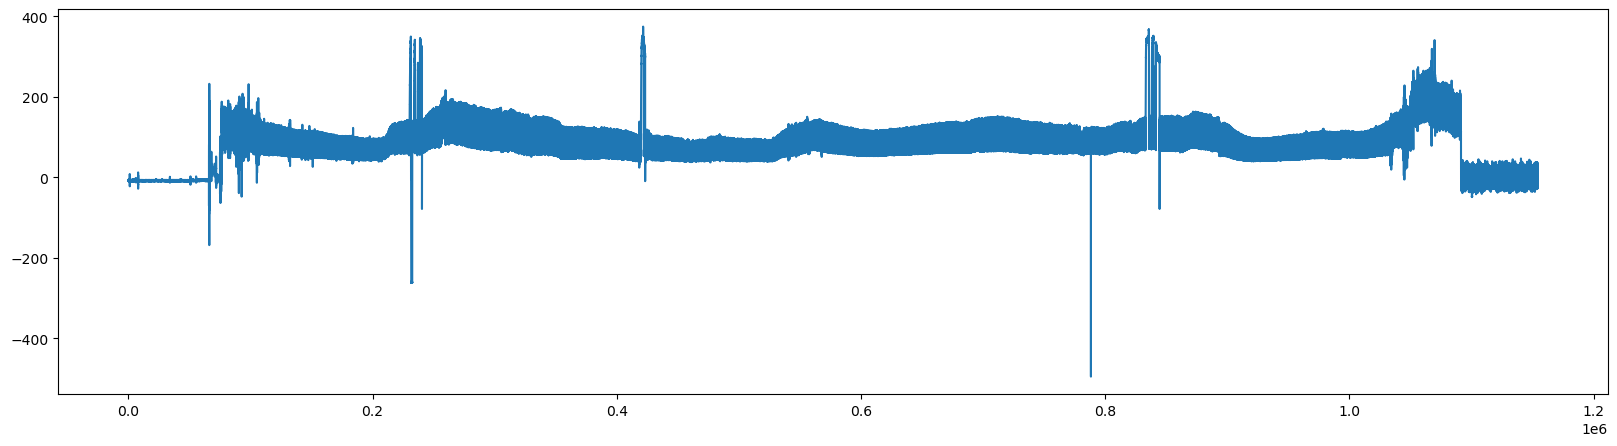

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(tmp_art_02[0][1])
plt.show()

**`vitaldb.vital_recs()`**

In [40]:
tmp_art_03 = vitaldb.vital_recs(tmp_vf_path, TRACK_NAMES[0], 1/100)
tmp_art_03.shape

(1154115, 1)

In [41]:
type(tmp_art_03)

numpy.ndarray

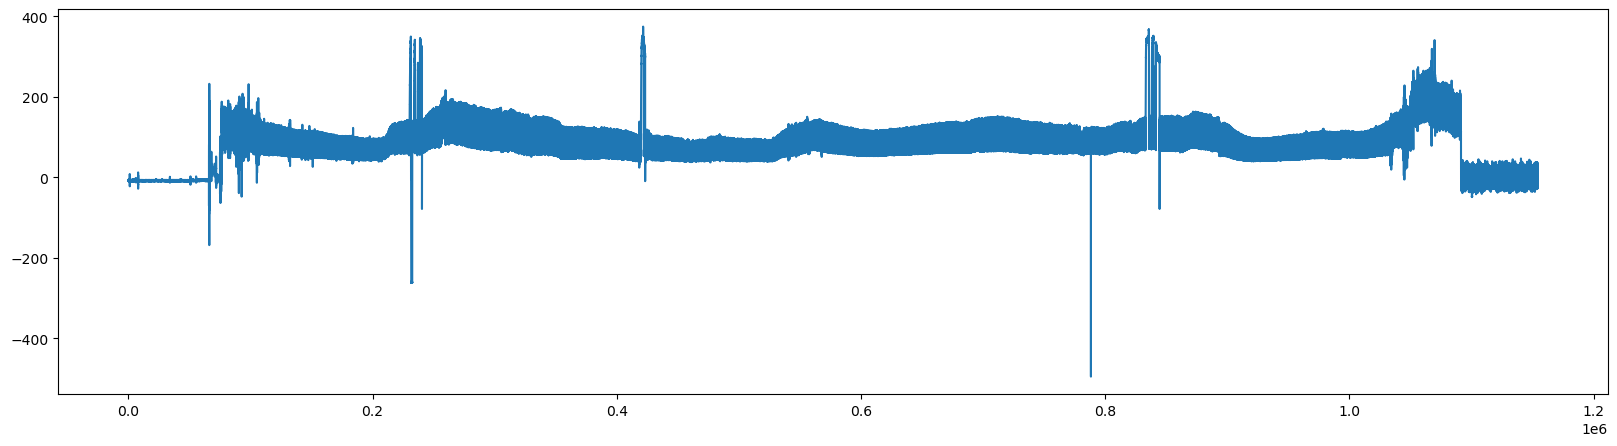

In [42]:
plt.figure(figsize=(20, 5))
plt.plot(tmp_art_03)
plt.show()

**`vitaldb.dataset.load_trk()`**

NOTE: This downloads a track based on raw id. Should not be needed, but showing how to do it.

In [43]:
SHOW_TRAK_DOWNLOAD = False

if SHOW_TRAK_DOWNLOAD:
    case_0001_trk_art_id = '724cdd7184d7886b8f7de091c5b135bd01949959'
    tmp_art_04 = vitaldb.dataset.load_trk(case_0001_trk_art_id, 1/100)
    print(tmp_art_04.shape)
    
    plt.figure(figsize=(20, 5))
    plt.plot(tmp_art_04)
    plt.show()
else:
    print('Manual track download example skipped.')

Manual track download example skipped.


# One Minute ABP Extraction

In [44]:
tmp_vf.dtstart

4102444800.947

In [45]:
start = datetime.datetime.fromtimestamp(tmp_vf.dtstart).isoformat()
start

'2099-12-31T18:00:00.947000'

In [46]:
end = datetime.datetime.fromtimestamp(tmp_vf.dtend).isoformat()
end

'2099-12-31T21:12:22.096763'

In [47]:
datetime.datetime.fromtimestamp(tmp_vf.dtend) - datetime.datetime.fromtimestamp(tmp_vf.dtstart)

datetime.timedelta(seconds=11541, microseconds=149763)

In [48]:
d = tmp_vf.get_dt(2024, 4, 1)
d

1711929600.0

In [49]:
datetime.datetime.fromtimestamp(d).isoformat()

'2024-03-31T19:00:00'

In [50]:
dd = tmp_vf.get_samples(TRACK_NAMES, 1)
type(dd)

tuple

In [51]:
tmp_art_00 = tmp_vf.get_track_samples(TRACK_NAMES[0], 1)
type(tmp_art_00)

numpy.ndarray

In [52]:
z = tmp_art_00[tmp_art_00 > 0]
z.shape

(10567,)

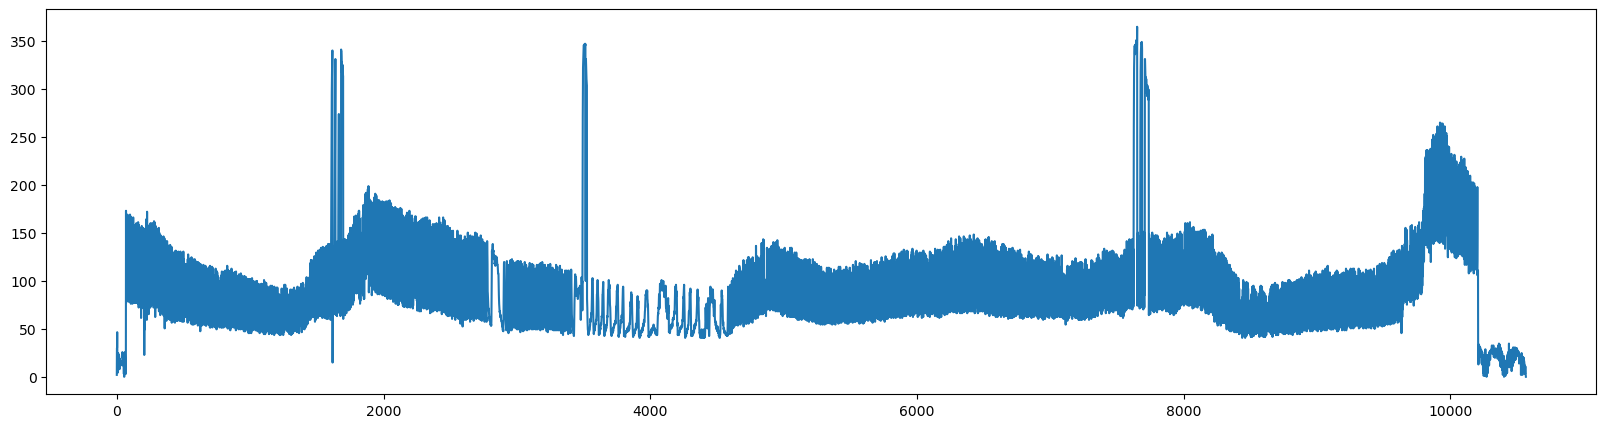

In [53]:
plt.figure(figsize=(20, 5))
plt.plot(z)
plt.show()

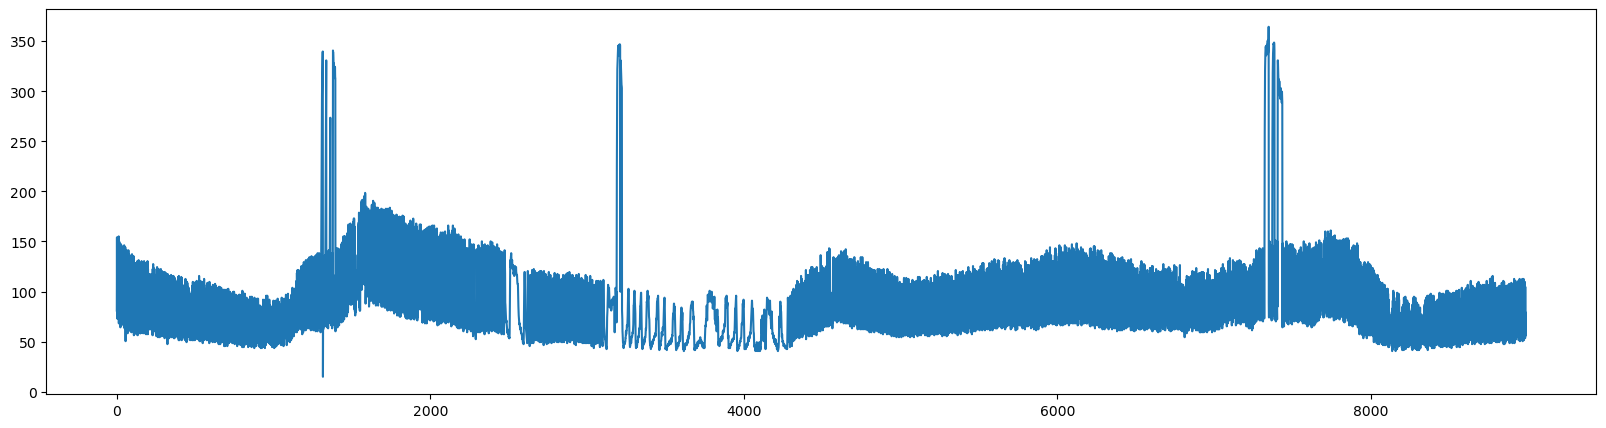

In [54]:
z = tmp_art_00[1000:10000].copy()
z = z[z > 0]

plt.figure(figsize=(20, 5))
plt.plot(z)
plt.show()

In [55]:
for caseid in cases_of_interest_idx[:1]:
    print(caseid)
    tmp_vf_path = f'{VITALDB_CACHE}/{VITAL_MINI}/{caseid:04d}_mini.vital'
    print(tmp_vf_path)
    tmp_vf = vitaldb.VitalFile(tmp_vf_path)
    arts = tmp_vf.to_numpy(TRACK_NAMES[0], 1/100)
    print(arts.ravel().shape)

1
./vitaldb_cache/vital_mini/0001_mini.vital
(1154115,)


In [56]:
# Generate hypotensive events
# Hypotensive events are defined as a 1-minute interval with sustained ABP of less than 65 mmHg
# Note: Hypotensive events should be at least 20 minutes apart to minimize potential residual effects from previous events
# TODO: Implement hypotension event generation function
# TODO: Generate hypotension events

# Generate hypotension non-events
# To sample non-events, 30-minute segments where the ABP was above 75 mmHG were selected, and then
# three one-minute samples of each waveform were obtained from the middle of the segment
# TODO: Implement hypotension non-event generation function
# TODO: Generate hypotension non-events

Adapted from: https://github.com/vitaldb/examples/blob/master/hypotension_art.ipynb

In [57]:
TRACK_NAMES

['SNUADC/ART', 'SNUADC/ECG_II', 'BIS/EEG1_WAV']

In [58]:
tmp_vf.get_track_samples(TRACK_NAMES[0], 1/500).shape

(5770575,)

In [59]:
tmp_vf.get_track_samples(TRACK_NAMES[1], 1/500).shape

(5770575,)

In [60]:
tmp_vf.get_track_samples(TRACK_NAMES[2], 1/128).shape

(1477268,)

In [61]:
tmp_vf.get_track_samples(TRACK_NAMES[2], 1/128).shape

(1477268,)

In [71]:
# Maximum number of cases to process.
COUNT_CASES = 10

# Sampling rate for ABP and ECG, Hz. These rates should be the same. Default = 500
ABP_ECG_SRATE_HZ = 500

# Sampling rate for EEG. Default = 128
EEG_SRATE_HZ = 128

# Length of feature segment, seconds.
FEATURE_LENGTH_SEC = 60
# Look ahead to predict hypotension, seconds.
MIDDLE_LENGTH_SEC  = 60 * 3
# Length of label segment, seconds.
LABEL_LENGTH_SEC   = 60

# Length to move down the ABP track for starting a new analysis segment, seconds.
NEW_SEGMENT_OFFSET_SEC = 10

# Final dataset for training and testing the model.
# inputs with shape of (segments, timepoints)
x_abp = []
x_ecg = []
x_eeg = []

# output with shape of (segments)
y = []

# validity of each segement; only valid segments are used for model building
valid_mask = []

# caseid of each segment
c = []

# Process each case and extract segments. For each segment identify presence of an event in the label zone.
time_start = timer()

for case_count, caseid in enumerate(cases_of_interest_idx[:COUNT_CASES]):
    print(f'Loading case: {caseid:04d}, ({case_count + 1} of {COUNT_CASES})')

    # read the arterial waveform
    tmp_vf_path = f'{VITALDB_CACHE}/{VITAL_MINI}/{caseid:04d}_mini.vital'
    tmp_vf = vitaldb.VitalFile(tmp_vf_path)
    
    abp = tmp_vf.to_numpy(TRACK_NAMES[0], 1/ABP_ECG_SRATE_HZ).ravel()
    ecg = tmp_vf.to_numpy(TRACK_NAMES[1], 1/ABP_ECG_SRATE_HZ).ravel()
    eeg = tmp_vf.to_numpy(TRACK_NAMES[2], 1/EEG_SRATE_HZ).ravel()
    
    # EEG - Different sample rate, process alone
    print(f'Length of {TRACK_NAMES[2]}:     {eeg.shape[0]}')
    
    print_first_segment = True

    last_sample_start_index = len(eeg) - EEG_SRATE_HZ * (FEATURE_LENGTH_SEC + MIDDLE_LENGTH_SEC + LABEL_LENGTH_SEC)
    sample_index_offset = NEW_SEGMENT_OFFSET_SEC * EEG_SRATE_HZ
    
    for i in range(0, last_sample_start_index, sample_index_offset):
        segx_start = i
        segx_end   = i + EEG_SRATE_HZ * FEATURE_LENGTH_SEC
        segx = eeg[segx_start:segx_end]
        
        if print_first_segment:
            print(f'  Feature Segment Length:   {segx.shape[0]} pts, {segx.shape[0] / EEG_SRATE_HZ} sec')
            print_first_segment = False

        # handle eeg, only care about extracting data from the same time interval used for abp
        x_eeg.append(eeg[segx_start:segx_end])    
    
    # ABP and ECG - Shared sample rate, process together    
    print(f'Length of {TRACK_NAMES[0]}:       {abp.shape[0]}')
    print(f'Length of {TRACK_NAMES[1]}:    {ecg.shape[0]}')

    segment_count = 0
    segment_valid = 0
    segment_event = 0
    print_first_segment = True

    last_sample_start_index = len(abp) - ABP_ECG_SRATE_HZ * (FEATURE_LENGTH_SEC + MIDDLE_LENGTH_SEC + LABEL_LENGTH_SEC)
    sample_index_offset = NEW_SEGMENT_OFFSET_SEC * ABP_ECG_SRATE_HZ
    
    for i in range(0, last_sample_start_index, sample_index_offset):
        segment_count += 1
        
        segx_start = i
        segx_end   = i + ABP_ECG_SRATE_HZ * FEATURE_LENGTH_SEC
        segx = abp[segx_start:segx_end]
        
        segy_start = i + ABP_ECG_SRATE_HZ * (FEATURE_LENGTH_SEC + MIDDLE_LENGTH_SEC)
        segy_end   = i + ABP_ECG_SRATE_HZ * (FEATURE_LENGTH_SEC + MIDDLE_LENGTH_SEC + LABEL_LENGTH_SEC)
        segy = abp[segy_start:segy_end]
        
        if print_first_segment:
            print(f'  Feature Segment Length:   {segx.shape[0]} pts, {segx.shape[0] / ABP_ECG_SRATE_HZ} sec')
            print(f'  Middle Segment Length:    {segy_start - segx_end} pts, {(segy_start - segx_end) / ABP_ECG_SRATE_HZ} sec')
            print(f'  Label Segment Length:     {segy.shape[0]} pts, {segy.shape[0] / ABP_ECG_SRATE_HZ} sec')
            print_first_segment = False

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        # 2 sec moving avg
        n = 2 * ABP_ECG_SRATE_HZ  
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        # forward filling - do this per case to avoid massive resource utilization at the end.
        segx = pd.DataFrame(segx).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)[0].values
        
        # Identify IOH event as < 65mm HG
        evt = np.nanmax(segy) < 65
        x_abp.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        # handle ecg, only care about extracting the same segment used for abp.
        # data is already time aligned and has same sample rate.
        x_ecg.append(ecg[segx_start:segx_end])
        
        if valid:
            segment_valid += 1
            if evt:
                segment_event += 1
    
    print(f'Total Segments Evaluated:   {segment_count}')
    segment_valid_percent = 0 if segment_count == 0 else 100 * segment_valid / segment_count 
    print(f'  Segments Valid:           {segment_valid}, {segment_valid_percent:.1f}%')
    segment_event_percent = 0 if segment_valid == 0 else 100 * segment_event / segment_valid
    print(f'  Segments with Event:      {segment_event}, {segment_event_percent:.1f}%')
    time_delta = np.round(timer() - time_start, 3)
    print(f'Total Processing Time:      {time_delta:.4f} sec')
    print()
    
# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x_abp = np.array(x_abp)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
#x_abp = pd.DataFrame(x_abp).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
#x_abp = pd.DataFrame(x_abp).values

# ABP normalization
x_abp -= 65
x_abp /= 65

# add axis for CNN; i.e. (# samples, feature segment length) -> (# samples, feature segment length, 1)
x_abp = x_abp[..., None]

# handle ecg
x_ecg = np.array(x_ecg)
x_ecg = x_ecg[..., None]

# handle eeg
x_eeg = np.array(x_eeg)
x_eeg = x_eeg[..., None]

# total processing time
time_end = timer()
time_delta = np.round(time_end - time_start, 3)

print('OVERALL SUMMARY')
print(f'Total Processing Time:      {time_delta:.4f} sec')
print(f'Total Cases Processed:      {caseids.shape[0]}')
print(f'Total Segments Evaluated:   {x_abp.shape[0]}')

segment_valid_count = np.sum(valid_mask)
segment_valid_percent = 0 if x_abp.shape[0] == 0 else 100 * segment_valid_count / x_abp.shape[0] 
print(f'  Segments Valid:           {segment_valid_count}, {segment_valid_percent:.1f}%')
segment_event_count = np.sum(y & valid_mask)
segment_event_percent = 0 if y.shape[0] == 0 else 100 * segment_event_count / y.shape[0]
print(f'  Segments with Event:      {segment_event_count}, {segment_event_percent:.1f}%')


print(f'Valid Samples Generated:    {(100 * np.mean(valid_mask)):.1f}%')
print()
print(f'Valid Mask Shape:           {valid_mask.shape}')
print(f'X_ABP Shape:                {x_abp.shape}')
print(f'X_ECG Shape:                {x_ecg.shape}')
print(f'X_EEG Shape:                {x_eeg.shape}')
print(f'Y Shape:                    {y.shape}')

Loading case: 0001, (1 of 10)
Length of BIS/EEG1_WAV:     1477268
  Feature Segment Length:   7680 pts, 60.0 sec
Length of SNUADC/ART:       5770575
Length of SNUADC/ECG_II:    5770575
  Feature Segment Length:   30000 pts, 60.0 sec
  Middle Segment Length:    90000 pts, 180.0 sec
  Label Segment Length:     30000 pts, 60.0 sec
Total Segments Evaluated:   1125
  Segments Valid:           775, 68.9%
  Segments with Event:      70, 9.0%
Total Processing Time:      1.0830 sec

Loading case: 0003, (2 of 10)
Length of BIS/EEG1_WAV:     562438
  Feature Segment Length:   7680 pts, 60.0 sec
Length of SNUADC/ART:       2197020
Length of SNUADC/ECG_II:    2197020
  Feature Segment Length:   30000 pts, 60.0 sec
  Middle Segment Length:    90000 pts, 180.0 sec
  Label Segment Length:     30000 pts, 60.0 sec
Total Segments Evaluated:   410
  Segments Valid:           0, 0.0%
  Segments with Event:      0, 0.0%
Total Processing Time:      1.4380 sec

Loading case: 0004, (3 of 10)
Length of BIS/EEG1

In [72]:
np.sum(y & valid_mask)

749

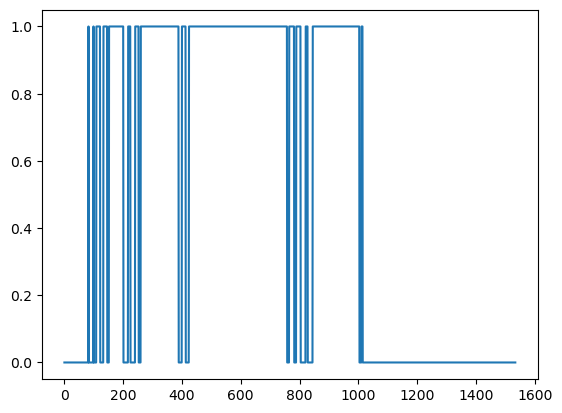

In [64]:
plt.plot(valid_mask);

In [65]:
valid_mask[190]

True

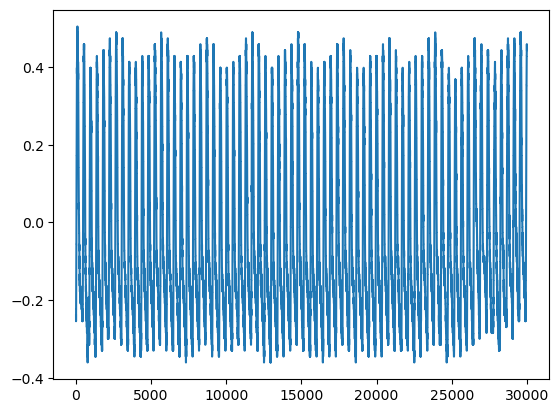

In [66]:
plt.plot(x_abp[190].ravel());

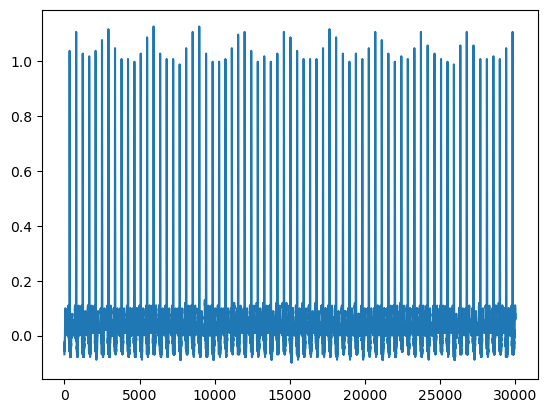

In [67]:
plt.plot(x_ecg[190].ravel());

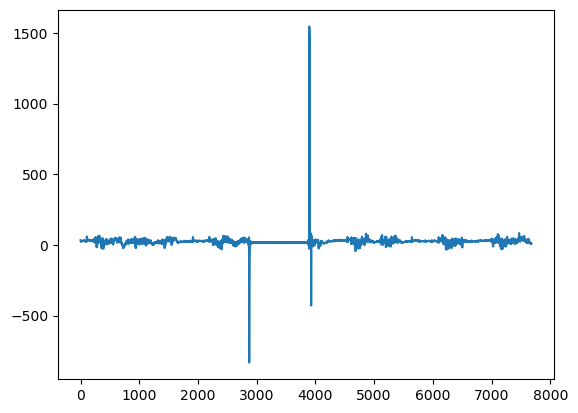

In [68]:
plt.plot(x_eeg[190].ravel());

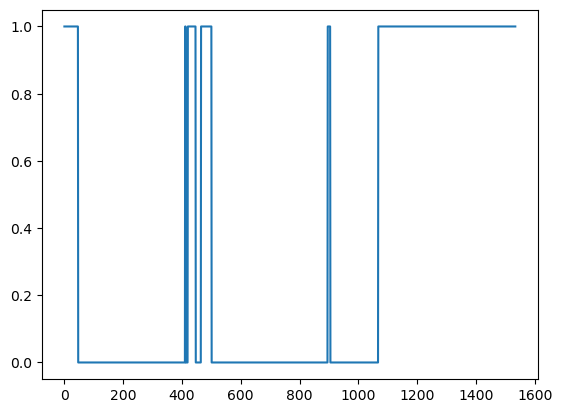

In [69]:
plt.plot(y);

In [70]:
xx = pd.DataFrame(x_abp.squeeze())
xx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535 entries, 0 to 1534
Columns: 30000 entries, 0 to 29999
dtypes: float64(30000)
memory usage: 351.3 MB
